In [68]:
# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# LDA
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.models import LdaModel

# aspect
from gensim.models import FastText
from scipy.spatial.distance import cosine

# model
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore", category = UserWarning)


In [4]:
df = pd.read_csv('D:/Coding/school/thesis dhewa/preprocessing/export/full_sentiment_processed_df.csv')
df

,processed_tokenized,final_sentence,Sentiment
0,['senang'],senang,Positive
1,"['mentok', 'melulu', 'di', 'pin', 'tiap', 'mau...",mentok melulu di pin tiap mau log in tidak bis...,Negative
2,"['aplikasi', 'sangat', 'bantu', 'saya', 'yang'...",aplikasi sangat bantu saya yang lagi hamil dal...,Positive
3,"['solusi', 'ibu', 'hamil']",solusi ibu hamil,Positive
4,"['aplikasi', 'parenting', 'lengkap', 'dan', 'b...",aplikasi parenting lengkap dan baik di indones...,Positive
...,...,...,...
344,['nan'],NaN,Neutral
345,"['padahal', 'bagus', 'suka', 'tapi', 'kenapa',...",padahal bagus suka tapi kenapa sekarang tidak ...,Negative
346,"['aplikasi', 'yang', 'sangat', 'bantu', 'untuk...",aplikasi yang sangat bantu untuk saya bagai ib...,Positive
347,['wow'],wow,Positive


In [5]:
df = df.dropna(subset=['final_sentence'])
df.isna().sum()

processed_tokenized    0
final_sentence         0
Sentiment              0
dtype: int64

# Getting the aspect

## LDA to predict the aspect

In [34]:
data_words = [review.split() for review in df['processed_tokenized'].dropna().astype(str)]
len(data_words)

310

In [35]:
print(data_words[:5])

[["['senang']"], ["['mentok',", "'melulu',", "'di',", "'pin',", "'tiap',", "'mau',", "'log',", "'in',", "'tidak',", "'bisa',", "'masuk',", "'terus']"], ["['aplikasi',", "'sangat',", "'bantu',", "'saya',", "'yang',", "'lagi',", "'hamil',", "'dalam',", "'pantau',", "'tumbuh',", "'kembang',", "'janin',", "'terima',", "'kasih',", "'banyak']"], ["['solusi',", "'ibu',", "'hamil']"], ["['aplikasi',", "'parenting',", "'lengkap',", "'dan',", "'baik',", "'di',", "'indonesia',", "'truncated',", "'for',", "'brevity']"]]


In [36]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_words]

# View
print(corpus)

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(28, 1), (29, 1), (30, 1)], [(2, 1), (27, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(39, 1), (40, 1)], [(41, 1), (42, 1)], [(16, 1), (22, 1), (26, 1), (27, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [(13, 1), (16, 1), (22, 1), (23, 1), (27, 1), (29, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(6, 1), (11, 1), (18, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(40, 1), (58, 1)], [(59, 1)], [(17, 1), (18, 1), (19, 1), (49, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)], [(67, 1), (68, 1)], [(13, 1), (40, 1), (47, 1), (69, 1), (70, 1), (71, 1)], [(15, 1), (27, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)], [(77, 1), (78, 1), (79, 1), (80, 1), (81, 1)], [(23, 1), (26,

In [41]:
# number of topics
num_topics = 15

# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"[\'aplikasi\'," + 0.029*"\'bantu\'," + 0.022*"\'banget\'," + '
  '0.022*"\'sangat\'," + 0.015*"\'untuk\'," + 0.015*"\'ini\'," + '
  '0.008*"\'sih\'," + 0.008*"[\'bantu\'," + 0.008*"\'asianparent\']" + '
  '0.008*"\'dapat\',"'),
 (1,
  '0.020*"\'sangat\'," + 0.015*"[\'aplikasi\'," + 0.015*"\'sampai\'," + '
  '0.010*"\'ovo\'," + 0.010*"\'kirim\'," + 0.010*"\'sudah\'," + '
  '0.010*"\'janin\'," + 0.010*"\'ini\'," + 0.010*"\'to\'," + '
  '0.010*"\'saldo\',"'),
 (2,
  '0.036*"[\'sangat\'," + 0.014*"\'bantu\'," + 0.014*"\'saja\'," + '
  '0.014*"\'sudah\'," + 0.009*"\'janin\'," + 0.009*"\'iya\'," + '
  '0.009*"\'lagi\'," + 0.009*"\'komen\'," + 0.009*"\'begitu\'," + '
  '0.009*"\'dengan\',"'),
 (3,
  '0.043*"\'tidak\'," + 0.036*"\'di\'," + 0.027*"\'nya\'," + '
  '0.024*"[\'aplikasi\'," + 0.024*"\'bisa\'," + 0.018*"\'yang\'," + '
  '0.018*"\'buka\'," + 0.012*"\'baru\'," + 0.012*"\'lancar\'," + '
  '0.012*"\'terus\',"'),
 (4,
  '0.025*"\'di\'," + 0.021*"\'baru\'," + 0.021*"\'tidak

🔹 2 Positive Aspects
1️⃣ Performance & Speed (Positif)

Words: cepat, lancar, ringan, smooth, responsif, stabil
Why? Many users praise the app’s speed, responsiveness, and smooth performance.
2️⃣ Features & Functionality (Positif)

Words: fitur, lengkap, membantu, inovatif, canggih, fungsional
Why? Users appreciate useful features, like tracking, e-wallet, and notifications.
🔹 2 Negative Aspects
3️⃣ Bugs & Errors (Negatif)

Words: error, crash, lambat, tidak bisa, bug, gagal, lemot
Why? Complaints about app crashes, errors, and performance issues.
4️⃣ App Updates & Changes (Negatif)

Words: update, berubah, hilang, downgrade, fitur kurang, tidak sesuai
Why? Users dislike bad updates, missing features, or unwanted changes.
🔹 1 Neutral Aspect
5️⃣ User Interface & Design (Netral)

Words: desain, tampilan, UI, warna, layout, ikon

We'll use these five aspects to create the similarity matrix using FastText embeddings. Each aspect has representative words to help classify sentences based on similarity.

Aspect	Sentiment	Keywords (Example words for similarity)
Performance & Speed	Positive	cepat, lancar, ringan, smooth, responsif, stabil
Features & Functionality	Positive	fitur, lengkap, membantu, inovatif, canggih, fungsional
Bugs & Errors	Negative	error, crash, lambat, tidak bisa, bug, gagal, lemot
App Updates & Changes	Negative	update, berubah, hilang, downgrade, fitur kurang, tidak sesuai
User Interface & Design	Neutral	desain, tampilan, UI, warna, layout, ikon

## Similarity Metrics

In [43]:
# Train FastText model
fasttext_model = FastText(data_words, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [45]:
# Aspect keywords
aspects = {
    "Performance & Speed": ["cepat", "lancar", "ringan", "smooth", "responsif", "stabil"],
    "Features & Functionality": ["fitur", "lengkap", "membantu", "inovatif", "canggih", "fungsional"],
    "Bugs & Errors": ["error", "crash", "lambat", "tidak bisa", "bug", "gagal", "lemot"],
    "App Updates & Changes": ["update", "berubah", "hilang", "downgrade", "fitur kurang", "tidak sesuai"],
    "User Interface & Design": ["desain", "tampilan", "UI", "warna", "layout", "ikon"]
}

# Compute aspect vectors
aspect_vectors = {aspect: np.mean([fasttext_model.wv[word] for word in words if word in fasttext_model.wv], axis=0) 
                  for aspect, words in aspects.items()}

In [ ]:
def get_aspect_similarity(text):
    text_vector = np.mean([fasttext_model.wv[word] for word in text if word in fasttext_model.wv], axis=0)
    similarities = {aspect: 1 - cosine(text_vector, aspect_vector) for aspect, aspect_vector in aspect_vectors.items()}
    return max(similarities, key=similarities.get)  # Return the most similar aspect

# Apply to all comments
df["aspect"] = df["processed_tokenized"].apply(get_aspect_similarity)

In [48]:

def get_aspect_similarities(text):
    text_vector = np.mean([fasttext_model.wv[word] for word in text if word in fasttext_model.wv], axis=0)

    # Compute cosine similarity for each aspect
    similarities = {aspect: 1 - cosine(text_vector, aspect_vector) for aspect, aspect_vector in aspect_vectors.items()}
    
    return similarities  # Return dictionary with all scores

# Apply function to all reviews
df_aspect_scores = df["processed_tokenized"].apply(get_aspect_similarities).apply(pd.Series)

# Merge with original DataFrame
df_final = df.join(df_aspect_scores)

# Show the first few rows
df_final

,processed_tokenized,final_sentence,Sentiment,Performance & Speed,Features & Functionality,Bugs & Errors,App Updates & Changes,User Interface & Design
0,['senang'],senang,Positive,-0.013929,-0.016290,-0.020538,-0.014177,-0.011142
1,"['mentok', 'melulu', 'di', 'pin', 'tiap', 'mau...",mentok melulu di pin tiap mau log in tidak bis...,Negative,0.162917,0.167684,0.154058,0.166947,0.177047
2,"['aplikasi', 'sangat', 'bantu', 'saya', 'yang'...",aplikasi sangat bantu saya yang lagi hamil dal...,Positive,0.122160,0.125455,0.116075,0.123234,0.142130
3,"['solusi', 'ibu', 'hamil']",solusi ibu hamil,Positive,0.131804,0.135719,0.125913,0.135160,0.150845
4,"['aplikasi', 'parenting', 'lengkap', 'dan', 'b...",aplikasi parenting lengkap dan baik di indones...,Positive,0.132960,0.136111,0.124924,0.135307,0.141645
...,...,...,...,...,...,...,...,...
343,"['aplikasi', 'yang', 'pakai', 'dari', 'awal', ...",aplikasi yang pakai dari awal program hamil sa...,Positive,0.129241,0.132980,0.120835,0.131961,0.154155
345,"['padahal', 'bagus', 'suka', 'tapi', 'kenapa',...",padahal bagus suka tapi kenapa sekarang tidak ...,Negative,0.115574,0.118651,0.106650,0.117571,0.141891
346,"['aplikasi', 'yang', 'sangat', 'bantu', 'untuk...",aplikasi yang sangat bantu untuk saya bagai ib...,Positive,0.133465,0.134439,0.125045,0.134813,0.148984
347,['wow'],wow,Positive,0.198535,0.193159,0.186851,0.201718,0.173089


In [80]:
def assign_aspect(row):
    max_sim = row.max()  # Get the highest similarity score
    if max_sim < 0:  
        return "Others"  # If all values are negative, assign "Others"
    return row.idxmax()  # Otherwise, assign the aspect with the highest similarity

# Apply the function to each row of similarity scores
df_final["predicted_aspect"] = df_aspect_scores.apply(assign_aspect, axis=1)

# Show results
df_final[['final_sentence', 'Sentiment', 'predicted_aspect']]

,final_sentence,Sentiment,predicted_aspect
0,senang,Positive,Others
1,mentok melulu di pin tiap mau log in tidak bis...,Negative,User Interface & Design
2,aplikasi sangat bantu saya yang lagi hamil dal...,Positive,User Interface & Design
3,solusi ibu hamil,Positive,User Interface & Design
4,aplikasi parenting lengkap dan baik di indones...,Positive,User Interface & Design
...,...,...,...
305,aplikasi yang pakai dari awal program hamil sa...,Positive,NaN
306,padahal bagus suka tapi kenapa sekarang tidak ...,Negative,NaN
307,aplikasi yang sangat bantu untuk saya bagai ib...,Positive,User Interface & Design
308,wow,Positive,Features & Functionality


# Model

In [138]:
# Define mapping for Sentiment
sentiment_mapping = {"Positive": 1, "Neutral": 1, "Negative": 0}

# Apply mapping to create "y" column
df_final["y"] = df_final["Sentiment"].map(sentiment_mapping)

# Display first few rows
df_final

,processed_tokenized,final_sentence,Sentiment,Performance & Speed,Features & Functionality,Bugs & Errors,App Updates & Changes,User Interface & Design,predicted_aspect,y
0,['senang'],senang,Positive,-0.013929,-0.016290,-0.020538,-0.014177,-0.011142,Others,1
1,"['mentok', 'melulu', 'di', 'pin', 'tiap', 'mau...",mentok melulu di pin tiap mau log in tidak bis...,Negative,0.162917,0.167684,0.154058,0.166947,0.177047,User Interface & Design,0
2,"['aplikasi', 'sangat', 'bantu', 'saya', 'yang'...",aplikasi sangat bantu saya yang lagi hamil dal...,Positive,0.122160,0.125455,0.116075,0.123234,0.142130,User Interface & Design,1
3,"['solusi', 'ibu', 'hamil']",solusi ibu hamil,Positive,0.131804,0.135719,0.125913,0.135160,0.150845,User Interface & Design,1
4,"['aplikasi', 'parenting', 'lengkap', 'dan', 'b...",aplikasi parenting lengkap dan baik di indones...,Positive,0.132960,0.136111,0.124924,0.135307,0.141645,User Interface & Design,1
...,...,...,...,...,...,...,...,...,...,...
305,"['aplikasi', 'yang', 'pakai', 'dari', 'awal', ...",aplikasi yang pakai dari awal program hamil sa...,Positive,0.129241,0.132980,0.120835,0.131961,0.154155,NaN,1
306,"['padahal', 'bagus', 'suka', 'tapi', 'kenapa',...",padahal bagus suka tapi kenapa sekarang tidak ...,Negative,0.115574,0.118651,0.106650,0.117571,0.141891,NaN,0
307,"['aplikasi', 'yang', 'sangat', 'bantu', 'untuk...",aplikasi yang sangat bantu untuk saya bagai ib...,Positive,0.133465,0.134439,0.125045,0.134813,0.148984,User Interface & Design,1
308,['wow'],wow,Positive,0.198535,0.193159,0.186851,0.201718,0.173089,Features & Functionality,1


In [139]:
class config:
    IMG_SIZE = (224,224)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
    FOLDS = 5
    SHUFFLE = True
    BATCH_SIZE = 32
    LR = 0.01
    EPOCHS = 30
    EMB_DIM = 100
    MAX_LEN = 20
    MODEL_PATH = "./Models/MyModel.pt"

In [140]:
# generate torch dataset

class Vocabulary:
  
    '''
    __init__ method is called by default as soon as an object of this class is initiated
    we use this method to initiate our vocab dictionaries
    '''
    def __init__(self, freq_threshold, max_size):
        '''
        freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
        max_size : max source vocab size. Eg. if set to 10,000, we pick the top 10,000 most frequent words and discard others
        '''
        #initiate the index to token dict
        ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
        ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
        ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
        ## <UNK> -> words which are not found in the vocab are replace by this token
        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}
        #initiate the token to index dict
        self.stoi = {k:j for j,k in self.itos.items()} 
        
        self.freq_threshold = freq_threshold
        self.max_size = max_size
    
    '''
    __len__ is used by dataloader later to create batches
    '''
    def __len__(self):
        return len(self.itos)
    
    '''
    a simple tokenizer to split on space and converts the sentence to list of words
    '''
    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]
    
    '''
    build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
    output ex. for stoi -> {'the':5, 'a':6, 'an':7}
    '''
    def build_vocabulary(self, sentence_list):
        #calculate the frequencies of each word first to remove the words with freq < freq_threshold
        frequencies = {}  #init the freq dict
        idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk
        
        #calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1
                    
                    
        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold} 
        
        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
            
        #create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1
            
     
    '''
    convert the list of words to a list of corresponding indexes
    '''    
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])
                
        return numericalized_text

In [141]:
class CustomDataset(Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    source_column : the name of source text column in the dataframe
    transform : If we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    '''
    
    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 , transform=None):
    
        self.df = df
        self.transform = transform
        
        #get source and target texts
        self.source_texts = self.df[source_column]
        
        
        ##VOCAB class has been created above
        #Initialize source vocab object and build vocabulary
        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())

        
    def __len__(self):
        return len(self.df)
    
    '''
    __getitem__ runs on 1 example at a time. Here, we get an example at index and return its numericalize source and
    target values using the vocabulary objects we created in __init__
    '''
    def __getitem__(self, index):
        source_text = self.source_texts[index]
        
        if self.transform is not None:
            source_text = self.transform(source_text)
            
        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])
        
        #convert the list to tensor and return
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

In [142]:
dataset = CustomDataset(df_final, "final_sentence")
len(dataset.source_vocab.stoi)

208

In [143]:
with open('dataset/dataset-new', 'wb') as dataset_file:
 
  # Step 3
    pickle.dump(dataset, dataset_file, pickle.HIGHEST_PROTOCOL)

# Word Embeddings

In [144]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable = False):

    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0
    
    for i, word in enumerate(target_vocab):
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1
                
    print(f"Words found are : {words_found}")
    
    weights_matrix = torch.tensor(weights_matrix, dtype = torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    print(emb_layer)
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [145]:
class MyCollate:
    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen
        
    
    #__call__: a default method
    ##   First the obj is created using MyCollate(pad_idx) in data loader
    ##   Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        #get all source indexed sentences of the batch
        source = [item[0] for item in batch] 
        #pad them using pad_sequence method from pytorch. 
#         source = pad_sequence(source, batch_first=False, padding_value = self.pad_idx)
        
        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)
        
        for idx, text in enumerate(source):
            
            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]
                
        
        #get all target indexed sentences of the batch
        target = [item[1] for item in batch] 
        
        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target

In [146]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()


        
    def forward(self, text):
        
        max_len, N = text.shape
        hidden = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        memory = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        hidden = hidden.to(config.DEVICE)
        memory = memory.to(config.DEVICE)
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded, (hidden, memory))
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        y_pred = output[-1,:,:]
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.sigmoid(y_pred)
                         
        return y_pred  

# Training

In [158]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [159]:
def train_epochs(dataloader, model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0
    all_labels = []
    all_predictions = []
    
    model.train()

    for review, label in tqdm(dataloader):
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * review.size(1)
        prediction = (output > 0.5).float()  # Convert to binary
        train_correct += (prediction == label).float().sum()
        
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(prediction.cpu().numpy())

    # Calculate accuracy
    train_acc = (train_correct / len(dataloader.dataset)) * 100
    
    # Ensure both labels and predictions are binary before passing to confusion matrix
    all_labels = [int(label) for label in all_labels]  # Ensure labels are integers
    all_predictions = [int(pred) for pred in all_predictions]  # Ensure predictions are integers
    
    return train_loss, train_acc, all_labels, all_predictions

In [160]:
def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0
    all_labels = []
    all_predictions = []
    
    model.eval()

    for review, label in dataloader:
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        
        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)
        
        val_loss += loss.item() * review.size(1)
        prediction = (output > 0.5).float()  # Convert to binary
        val_correct += (prediction == label).float().sum()

        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(prediction.cpu().numpy())
    
    # Calculate accuracy
    val_acc = (val_correct / len(dataloader.dataset)) * 100
    
    # Ensure both labels and predictions are binary before passing to confusion matrix
    all_labels = [int(label) for label in all_labels]  # Ensure labels are integers
    all_predictions = [int(pred) for pred in all_predictions]  # Ensure predictions are integers
    
    return val_loss, val_acc, all_labels, all_predictions


best_val_acc = 0  # Track the best validation accuracy
best_fold = None  # Store the fold number with the best validation accuracy
best_model_state_dict = None  # Store the best model state dict
best_train_loss = None  # Store the best training loss
best_val_loss = None  # Store the best validation loss



Words found are : 208
Embedding(208, 100)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 42.42it/s]


| Train Loss : 0.6899268823919944 | Val Loss : 0.6789893003610464 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 42.37it/s]


| Train Loss : 0.6853866484558698 | Val Loss : 0.6703912799174969 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 49.02it/s]


| Train Loss : 0.6824605528590748 | Val Loss : 0.6660288480611948 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 43.01it/s]


| Train Loss : 0.6811945507827314 | Val Loss : 0.6618398565512437 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 45.62it/s]


| Train Loss : 0.6802406073773949 | Val Loss : 0.6593526189143841 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.59it/s]


| Train Loss : 0.6803646081859626 | Val Loss : 0.6590642745678241 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.83it/s]

| Train Loss : 0.6798184872830956 |

 Val Loss : 0.6564922699561486 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 45.53it/s]

| Train Loss : 0.679775118249134 | Val Loss : 0.6559144808695867 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 45.78it/s]


| Train Loss : 0.6806078205988245 | Val Loss : 0.6557122377248911 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.78it/s]


| Train Loss : 0.6803823935175405 | Val Loss : 0.6579920053482056 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.32it/s]


| Train Loss : 0.680199615006308 | Val Loss : 0.6586255522874686 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 50.67it/s]

| Train Loss : 0.6813789062129642 |

 Val Loss : 0.6595571407904992 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 48.45it/s]

| Train Loss : 0.6810707380470721 |

 Val Loss : 0.6608431339263916 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]

| Train Loss : 0.6801913693113234 | Val Loss : 0.6607264234469488 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 50.08it/s]

| Train Loss : 0.6802205865822949 |

 Val Loss : 0.658913832444411 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 48.69it/s]

| Train Loss : 0.6800022391439642 | Val Loss : 0.6570455386088445 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 48.51it/s]


| Train Loss : 0.6797627881892676 | Val Loss : 0.6550300350556006 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 28.86it/s]


| Train Loss : 0.6797184324958949 | Val Loss : 0.6541527051192063 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 51.24it/s]


| Train Loss : 0.6798001956013799 | Val Loss : 0.6559121746283311 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 52.62it/s]


| Train Loss : 0.6800699135632191 | Val Loss : 0.6567034354576697 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.36it/s]

| Train Loss : 0.6796660226525613 | Val Loss : 0.6559275388717651 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 47.71it/s]


| Train Loss : 0.6797434473500669 | Val Loss : 0.6567443930185758 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 52.01it/s]


| Train Loss : 0.6797529482147069 | Val Loss : 0.6564366404826825 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 49.82it/s]


| Train Loss : 0.6800477001273516 | Val Loss : 0.6554653323613681 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 52.44it/s]


| Train Loss : 0.679723615206561 | Val Loss : 0.6536029898203336 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 49.93it/s]

| Train Loss : 0.6796316035742899 | Val Loss : 0.654123631807474 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 47.28it/s]

| Train Loss : 0.6797000401228377 |

 Val Loss : 0.6562571342174823 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.31it/s]

| Train Loss : 0.6796579117913848 | Val Loss : 0.6567463737267715 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 50.89it/s]


| Train Loss : 0.6797566141897035 | Val Loss : 0.6568768803889935 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 42.54it/s]


| Train Loss : 0.6796914987193728 | Val Loss : 0.6569053943340595 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |
Words found are : 208
Embedding(208, 100)


100%|██████████| 7/7 [00:00<00:00, 48.02it/s]


| Train Loss : 0.6958211910897407 | Val Loss : 0.6938648536367323 | Train Acc : 30.967742919921875 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 49.58it/s]


| Train Loss : 0.6727495029352714 | Val Loss : 0.6994865224199388 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 47.43it/s]

| Train Loss : 0.6587166005862508 | Val Loss : 0.7067342967662996 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 49.73it/s]

| Train Loss : 0.6522846610649772 | Val Loss : 0.7138516249008549 | 

Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 48.37it/s]

| Train Loss : 0.6479479794341009 | Val Loss : 0.7197769961310821 | 

Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 46.76it/s]

| Train Loss : 0.6460948828337849 | Val Loss : 0.7243670531846944 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 50.84it/s]

| Train Loss : 0.6454016511566973 | Val Loss : 0.7265994774485097 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 29.02it/s]


| Train Loss : 0.6445291986787952 | Val Loss : 0.7328679850957927 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 50.18it/s]

| Train Loss : 0.6439796501887594 |

 Val Loss : 0.7356421606054584 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 49.19it/s]


| Train Loss : 0.6441410468972247 | Val Loss : 0.7362402891649783 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 57.22it/s]


| Train Loss : 0.6435785437551673 | Val Loss : 0.7389426283466006 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 48.58it/s]

| Train Loss : 0.6433217773115002 | Val Loss : 0.7383211457613602 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 51.25it/s]

| Train Loss : 0.6442463919160447 | Val Loss : 0.7421463542771571 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 46.14it/s]

| Train Loss : 0.6434471244397371 | Val Loss : 0.7403667106211764 | 

Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 51.47it/s]

| Train Loss : 0.6437986349138085 | Val Loss : 0.7403531196047959 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 49.40it/s]

| Train Loss : 0.643925831945622 | Val Loss : 0.7453925858423548 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 47.49it/s]


| Train Loss : 0.6432455115848117 | Val Loss : 0.7470040425513554 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 52.12it/s]


| Train Loss : 0.6443025037862252 | Val Loss : 0.7463637960767283 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 48.70it/s]

| Train Loss : 0.6434345009246311 |

 Val Loss : 0.7452467708911711 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 49.90it/s]


| Train Loss : 0.6432672862845342 | Val Loss : 0.7437468275283147 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 49.53it/s]

| Train Loss : 0.6433035339710217 |

 Val Loss : 0.7431788103094379 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 48.05it/s]

| Train Loss : 0.6438458253795974 | Val Loss : 0.7368917042769275 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |



100%|██████████| 7/7 [00:00<00:00, 49.61it/s]

| Train Loss : 0.6439161338092049 |

 Val Loss : 0.7426355128149384 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 38.36it/s]


| Train Loss : 0.643593082393425 | Val Loss : 0.741445883385186 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 49.75it/s]

| Train Loss : 0.6434159952661266 |

 Val Loss : 0.7395988882166667 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 49.30it/s]

| Train Loss : 0.6432848667752915 |

 Val Loss : 0.739041931420854 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 27.11it/s]


| Train Loss : 0.6435735490587022 | Val Loss : 0.7374513357588388 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 46.04it/s]


| Train Loss : 0.6433780406408264 | Val Loss : 0.7372205784019915 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 45.69it/s]

| Train Loss : 0.6436419121309179 |

 Val Loss : 0.7350745727714983 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |


100%|██████████| 7/7 [00:00<00:00, 45.52it/s]


| Train Loss : 0.6435599361640819 | Val Loss : 0.7353058769864943 | Train Acc : 43.870967864990234 | Val Acc : 16.774194717407227 |
Words found are : 208
Embedding(208, 100)


100%|██████████| 7/7 [00:00<00:00, 49.68it/s]

| Train Loss : 0.6892788603110014 | Val Loss : 0.6771254990864726 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 49.93it/s]


| Train Loss : 0.6851255597123778 | Val Loss : 0.672467841685397 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.76it/s]


| Train Loss : 0.6843132414103706 | Val Loss : 0.669748045287086 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 50.18it/s]


| Train Loss : 0.682865646150377 | Val Loss : 0.6651858878367155 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 50.57it/s]

| Train Loss : 0.6820874542429827 |

 Val Loss : 0.6625173207625602 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.91it/s]


| Train Loss : 0.68189437435445 | Val Loss : 0.6593594973527112 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.07it/s]


| Train Loss : 0.6811877201144821 | Val Loss : 0.658027587006393 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 44.17it/s]


| Train Loss : 0.6809077510511242 | Val Loss : 0.656974976502576 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 41.72it/s]


| Train Loss : 0.6809244023429023 | Val Loss : 0.6559296655423433 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 50.84it/s]


| Train Loss : 0.6807447640216293 | Val Loss : 0.6538956147953144 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.99it/s]


| Train Loss : 0.6807650195227729 | Val Loss : 0.653483766953922 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 49.65it/s]

| Train Loss : 0.6805550507877184 | Val Loss : 0.6542336738225326 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



100%|██████████| 7/7 [00:00<00:00, 48.24it/s]

| Train Loss : 0.680561175380928 |

 Val Loss : 0.6540201468375123 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 45.40it/s]


| Train Loss : 0.6809161077950887 | Val Loss : 0.6551812285358466 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 28.25it/s]


| Train Loss : 0.6807850472593077 | Val Loss : 0.6538129379448382 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 51.06it/s]


| Train Loss : 0.6804850222407908 | Val Loss : 0.6538795365870578 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 49.15it/s]

| Train Loss : 0.6808379295367549 |

 Val Loss : 0.6521051375611314 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.96it/s]

| Train Loss : 0.6808715989624244 |

 Val Loss : 0.6528945513141965 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.93it/s]

| Train Loss : 0.6809021171164398 |

 Val Loss : 0.6528003348887546 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 48.08it/s]


| Train Loss : 0.6807687564748497 | Val Loss : 0.6535240758969946 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.92it/s]

| Train Loss : 0.6806025104822168 |

 Val Loss : 0.6521168466910575 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 49.87it/s]

| Train Loss : 0.6809641854198658 | Val Loss : 0.6524666657725584 | 

Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 40.19it/s]


| Train Loss : 0.681229513336495 | Val Loss : 0.6511707132302441 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 45.62it/s]


| Train Loss : 0.6807767414816336 | Val Loss : 0.6518663329985536 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.99it/s]

| Train Loss : 0.6809317196048976 |

 Val Loss : 0.65265070176819 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.34it/s]


| Train Loss : 0.6812593968594132 | Val Loss : 0.6524825964159179 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 50.68it/s]

| Train Loss : 0.6806359023287676 |

 Val Loss : 0.6518308080515816 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 46.22it/s]

| Train Loss : 0.6813570511513862 | Val Loss : 0.6521261826302241 | Train Acc : 38.70967483520508 | 

Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 51.24it/s]

| Train Loss : 0.6813953294270281 |

 Val Loss : 0.6529887318611145 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |


100%|██████████| 7/7 [00:00<00:00, 47.70it/s]

| Train Loss : 0.6811242909823063 | Val Loss : 0.6530883468470527 | Train Acc : 38.70967483520508 | Val Acc : 21.935483932495117 |



Best Model (Fold 0):
Train Accuracy: 38.70967483520508
Validation Accuracy: 21.935483932495117
Train Loss: 0.6796914987193728
Validation Loss: 0.6569053943340595


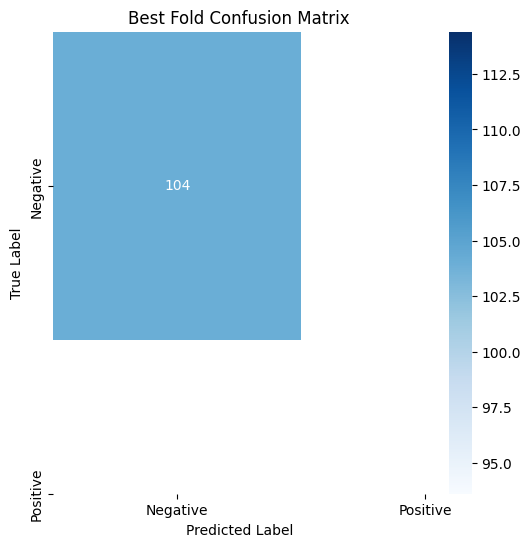

In [161]:
# Initialize tracking variables
best_train_acc = 0
best_val_acc = 0
best_cm = None  # Store confusion matrix for the best fold

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, sampler=train_sampler, collate_fn=MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, sampler=val_sampler, collate_fn=MyCollate(0, config.MAX_LEN))

    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab=VOCAB, emb_model=fasttext_model, trainable=False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Train and validation metrics for this fold
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(config.EPOCHS):
        train_loss, train_acc, _, _ = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc, _, _ = val_epochs(val_loader, model, loss_fn)

        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(val_loader.sampler)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print the results for each epoch
        print(f"| Train Loss : {train_loss} |", end=" ")
        print(f"Val Loss : {val_loss} |", end=" ")
        print(f"Train Acc : {train_acc} |", end=" ")
        print(f"Val Acc : {val_acc} |")

    # After all epochs in this fold, check if this fold's validation accuracy is the best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_train_acc = train_acc
        best_val_loss = val_loss
        best_train_loss = train_loss
        best_fold = fold
        best_model_state_dict = model.state_dict()
        best_cm = confusion_matrix(_, _)  # Use the best labels and predictions from this fold

# Print the best results
print(f"\nBest Model (Fold {best_fold}):")
print(f"Train Accuracy: {best_train_acc}")
print(f"Validation Accuracy: {best_val_acc}")
print(f"Train Loss: {best_train_loss}")
print(f"Validation Loss: {best_val_loss}")

# Plot the confusion matrix for the best fold after all epochs are done
plot_confusion_matrix(best_cm, title="Best Fold Confusion Matrix")

In [162]:
# You can save the best model if desired
torch.save(best_model_state_dict, "model/My-Model.pt")

## No Fold

In [148]:
def train_epochs(dataloader, model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0
    all_labels = []
    all_predictions = []
    
    model.train()

    for review, label in tqdm(dataloader):
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * review.size(1)
        
        # Modify prediction to 0, 0.5, or 1 based on the output
        prediction = torch.where(output < 0.25, torch.tensor(0.0), 
                                 torch.where(output < 0.75, torch.tensor(0.5), torch.tensor(1.0)))
        
        # Count correct predictions
        train_correct += (prediction == label).float().sum()
        
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(prediction.cpu().numpy())

    train_acc = (train_correct / len(dataloader.dataset)) * 100
    
    return train_loss, train_acc, all_labels, all_predictions

def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0
    all_labels = []
    all_predictions = []
    
    model.eval()

    for review, label in dataloader:
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        
        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)
        
        val_loss += loss.item() * review.size(1)
        
        # Modify prediction to 0, 0.5, or 1 based on the output
        prediction = torch.where(output < 0.25, torch.tensor(0.0), 
                                 torch.where(output < 0.75, torch.tensor(0.5), torch.tensor(1.0)))
        
        val_correct += (prediction == label).float().sum()

        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(prediction.cpu().numpy())
    
    val_acc = (val_correct / len(dataloader.dataset)) * 100
    
    return val_loss, val_acc, all_labels, all_predictions

100%|██████████| 10/10 [00:00<00:00, 25.76it/s]


| Train Loss : 0.6694911345358818 | Val Loss : 0.6690710298476681 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 36.36it/s]


| Train Loss : 0.6697748414931759 | Val Loss : 0.6690645217895508 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.34it/s]


| Train Loss : 0.6696968928460152 | Val Loss : 0.6691485574168544 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 43.40it/s]


| Train Loss : 0.6697839056291888 | Val Loss : 0.6690836237322899 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 48.72it/s]


| Train Loss : 0.6692982631344949 | Val Loss : 0.6690742765703509 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.05it/s]


| Train Loss : 0.6694462110919337 | Val Loss : 0.6689478270469174 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.10it/s]


| Train Loss : 0.6694830659897096 | Val Loss : 0.668931120826352 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.55it/s]


| Train Loss : 0.6702146653206118 | Val Loss : 0.668914419604886 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 51.80it/s]


| Train Loss : 0.6699872424525599 | Val Loss : 0.6689007028456657 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.76it/s]


| Train Loss : 0.6696327886273784 | Val Loss : 0.668893547211924 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 47.35it/s]


| Train Loss : 0.6691228901186297 | Val Loss : 0.6688782818855777 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 51.15it/s]


| Train Loss : 0.6694165233642825 | Val Loss : 0.6688515555474066 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 42.27it/s]


| Train Loss : 0.6692253347366087 | Val Loss : 0.6688318087208656 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.14it/s]


| Train Loss : 0.66973261333281 | Val Loss : 0.6688157243113364 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 40.53it/s]


| Train Loss : 0.669955873873926 | Val Loss : 0.668792183937565 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 43.58it/s]


| Train Loss : 0.6699928668237501 | Val Loss : 0.6687798469297348 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 48.30it/s]


| Train Loss : 0.6692641777376975 | Val Loss : 0.6687562492585951 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 48.42it/s]


| Train Loss : 0.6699490916344427 | Val Loss : 0.6687402367591858 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 45.65it/s]


| Train Loss : 0.6697961415013959 | Val Loss : 0.6687641978263855 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.77it/s]


| Train Loss : 0.6696513245182653 | Val Loss : 0.6687633495176992 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 46.57it/s]


| Train Loss : 0.669152997386071 | Val Loss : 0.6688143718627191 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 39.98it/s]


| Train Loss : 0.6693271560053672 | Val Loss : 0.6686795673062724 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 44.54it/s]


| Train Loss : 0.6689305347781027 | Val Loss : 0.6686402590044083 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 49.10it/s]


| Train Loss : 0.6694100610671505 | Val Loss : 0.6686192831685466 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 48.42it/s]


| Train Loss : 0.6693093780548341 | Val Loss : 0.668606839641448 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 49.36it/s]


| Train Loss : 0.6690191980331175 | Val Loss : 0.6686101825006546 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 43.43it/s]


| Train Loss : 0.6692617804773392 | Val Loss : 0.6685573581726321 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 29.65it/s]


| Train Loss : 0.668847454747846 | Val Loss : 0.6685416075491136 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 48.72it/s]


| Train Loss : 0.6695075361959396 | Val Loss : 0.6685119459705968 | Train Acc : 0.0 | Val Acc : 0.0 |


100%|██████████| 10/10 [00:00<00:00, 45.08it/s]


| Train Loss : 0.6690904517327586 | Val Loss : 0.6684889289640611 | Train Acc : 0.0 | Val Acc : 0.0 |

Model Performance Metrics after Training:
Accuracy: 0.6064516129032258
Recall: 1.0
F1 Score: 0.7550200803212851
Confusion Matrix:
[[   0 3660]
 [   0 5640]]


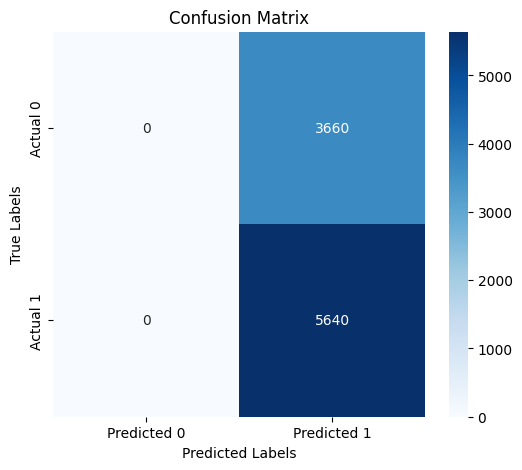

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Initialize tracking variables for all metrics
all_true_labels = []
all_preds = []
all_probs = []

# Train the model for all epochs
for epoch in range(config.EPOCHS):
    train_loss, train_acc, _, _ = train_epochs(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc, _, _ = val_epochs(val_loader, model, loss_fn)

    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(val_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # After validation, collect true labels and predictions
    with torch.no_grad():
        model.eval()
        true_labels = []
        preds = []
        probs = []  # Store probabilities for AUC calculation
        for data, label in val_loader:
            output = model(data)
            
            # Apply sigmoid to get probabilities (keep as tensor)
            prob = torch.sigmoid(output).cpu()  # Ensure it's a tensor
            predictions = torch.round(prob)  # Convert probabilities to binary predictions (0 or 1)
            
            true_labels.extend(label.cpu().numpy())
            preds.extend(predictions.cpu().numpy())
            probs.extend(prob.cpu().numpy())  # Store probabilities for AUC calculation

        # Store the true labels and predictions for metrics calculation
        all_true_labels.extend(true_labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

    # Print the results for each epoch
    print(f"| Train Loss : {train_loss} |", end=" ")
    print(f"Val Loss : {val_loss} |", end=" ")
    print(f"Train Acc : {train_acc} |", end=" ")
    print(f"Val Acc : {val_acc} |")

# Calculate performance metrics after all epochs
accuracy = accuracy_score(all_true_labels, all_preds)
recall = recall_score(all_true_labels, all_preds)
f1 = f1_score(all_true_labels, all_preds)
cm = confusion_matrix(all_true_labels, all_preds)  # Confusion matrix

# Print the calculated metrics
print(f"\nModel Performance Metrics after Training:")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Inferencing